In [1]:
# データ分析・操作用ライブラリ
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

# NLP用ライブラリ
import MeCab,re
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import word2vec

# スコア評価用ライブラリ
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support

# エラー表示の抑制
import warnings

In [2]:
# 表示関連
# DataFrameの列数設定
pd.set_option('display.max_columns', 500)
pd.set_option("display.max_rows", 500)
warnings.filterwarnings('ignore')

In [3]:
def tokenize(text):
    tokens = []
    tagger = MeCab.Tagger()
    node = tagger.parseToNode(text)
    while node:
        if node.feature.split(",")[0] in ['名詞'] :
                replace_node = re.sub( re.compile( "[!-/:-@[-`{-~]" ), "", node.surface )
                if replace_node != "" and replace_node != " ":
                    tokens.append(replace_node)
        node = node.next
    return tokens

In [4]:
def EmbeddingVectorizer(arr, model):
    mean_sum_vectors = []
    for document in arr:
        tokens = tokenize(document)
        vectors = [model[token] for token in tokens if token in model]
        if vectors:
            mean_vec = np.vstack(vectors).mean(axis=0)
            sum_vec = np.vstack(vectors).mean(axis=0)
            mean_sum_vectors.append(np.hstack((mean_vec,sum_vec)))
        else:
            mean_sum_vectors.append(np.zeros(200))
        embedding = np.vstack(mean_sum_vectors)        
    return embedding

In [5]:
# テキストデータの読み込み
wikiData = pd.read_csv("csv/train_cleaned.csv", encoding="utf-8")

# 読み込みデータの表示
wikiData.head()

,text,target
0,ドール・フード・カンパニー ドール・フード・カンパニー Dole Food Comp...,1
1,南ヶ丘牧場 株式会社 南ヶ丘牧場 みなみ じょう 栃木県 那須高原 本拠 酪...,1
2,岩瀬牧場 岩瀬牧場 ぼくじょう 日本 福島県 岩瀬 郡 鏡石町 牧場 鏡石...,1
3,くら ぎ GI Co Ltd 三重県 中心 農業 店舗 展開 会社 本...,1
4,ハッピーネモファーム 株式会社 ハッピーネモファーム 北海道 浦河 郡 浦河町 ...,1


In [6]:
# Numpy配列へ変換
X = wikiData.text.values
y = wikiData.target.values

In [7]:
# トレーニングデータ、テストデータの分割
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.2, random_state=42, stratify=y)

In [8]:
# 分散表現の読み込み
model_dir = 'model/word2vec.model'
model = word2vec.Word2Vec.load(model_dir)

In [9]:
# 分散表現へ変換
X_train = EmbeddingVectorizer(X_train, model)
X_test = EmbeddingVectorizer(X_test, model)

In [10]:
# Light GBM
import lightgbm as lgb

clf = lgb.LGBMClassifier(objective='multiclass', num_class=33)
clf.fit(X_train, y_train)
cv_scores = cross_val_score(clf, X_train, y_train, cv=5)

print("Training score：" + str(clf.score(X_train, y_train)))
print("Cross-Validation score：" + str(np.mean(cv_scores)))
print("Test score：" + str(clf.score(X_test, y_test)))

Training score：1.0
Cross-Validation score：0.673386608154
Test score：0.6525534701


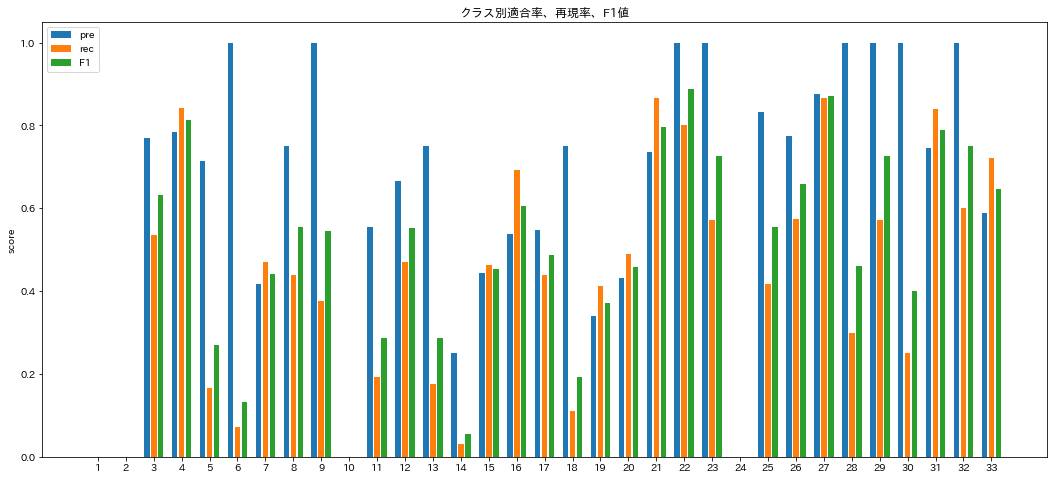

In [11]:
# テストスコアのクラス別適合率、再現率、F1値を計算
pred_test = clf.predict(X_test)
p_r_f = precision_recall_fscore_support(y_test, pred_test)
wiki_gpby = wikiData.groupby('target').count()
y = wiki_gpby['text'].values
x =wiki_gpby.index.values

# クラス別適合率、再現率、F1値を表示
plt.figure(figsize=(18, 8))
plt.title("クラス別適合率、再現率、F1値")
plt.ylabel("score")
plt.xticks(x)
plt.bar(x-0.25, p_r_f[0], width=0.2, label='pre')
plt.bar(x, p_r_f[1], width=0.2, label='rec')
plt.bar(x+0.25, p_r_f[2], width=0.2, label='F1')
plt.legend(loc=2)    
plt.show()

In [12]:
# ロジスティック回帰
from sklearn.linear_model import LogisticRegression

## multinomial
clf2 = LogisticRegression(solver='lbfgs', multi_class = 'multinomial', random_state=42)
clf2.fit(X_train, y_train)
cv_scores = cross_val_score(clf2, X_train, y_train, cv=5)

print("Training score：" + str(clf2.score(X_train, y_train)))
print("Cross-Validation score：" + str(np.mean(cv_scores)))
print("Test score：" + str(clf2.score(X_test, y_test)))
                          
## One-versus-the-rest
clf3 = LogisticRegression(solver='liblinear', multi_class = 'ovr', random_state=42)
clf3.fit(X_train, y_train)
cv_scores = cross_val_score(clf3, X_train, y_train, cv=5)

print("Training score：" + str(clf3.score(X_train, y_train)))
print("Cross-Validation score：" + str(np.mean(cv_scores)))
print("Test score：" + str(clf3.score(X_test, y_test)))

Training score：0.799869052815
Cross-Validation score：0.720759622903
Test score：0.728939327804
Training score：0.781754692274
Cross-Validation score：0.722856088292
Test score：0.732431252728


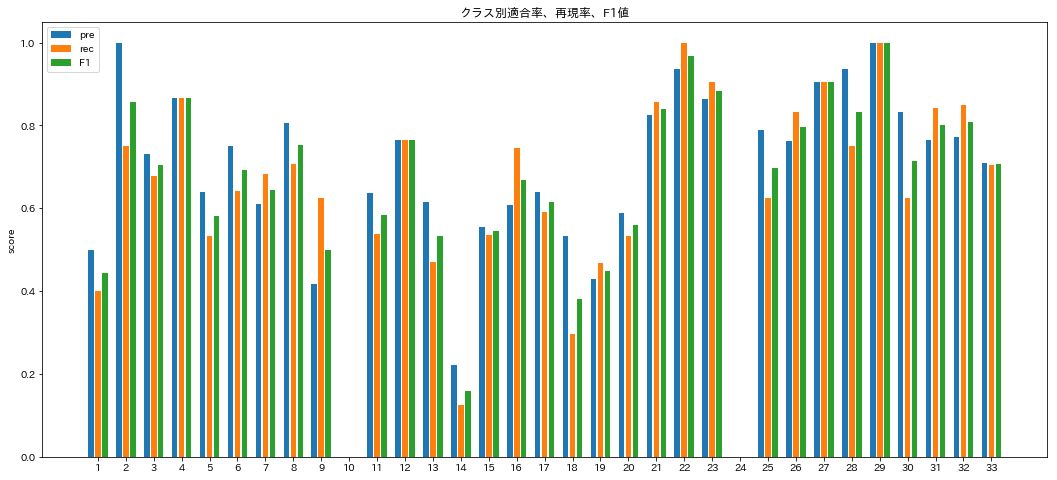

In [13]:
# テストスコアのクラス別適合率、再現率、F1値を計算
pred_test = clf2.predict(X_test)
p_r_f = precision_recall_fscore_support(y_test, pred_test)

# クラス別適合率、再現率、F1値を表示
plt.figure(figsize=(18, 8))
plt.title("クラス別適合率、再現率、F1値")
plt.ylabel("score")
plt.xticks(x)
plt.bar(x-0.25, p_r_f[0], width=0.2, label='pre')
plt.bar(x, p_r_f[1], width=0.2, label='rec')
plt.bar(x+0.25, p_r_f[2], width=0.2, label='F1')
plt.legend(loc=2)    
plt.show()

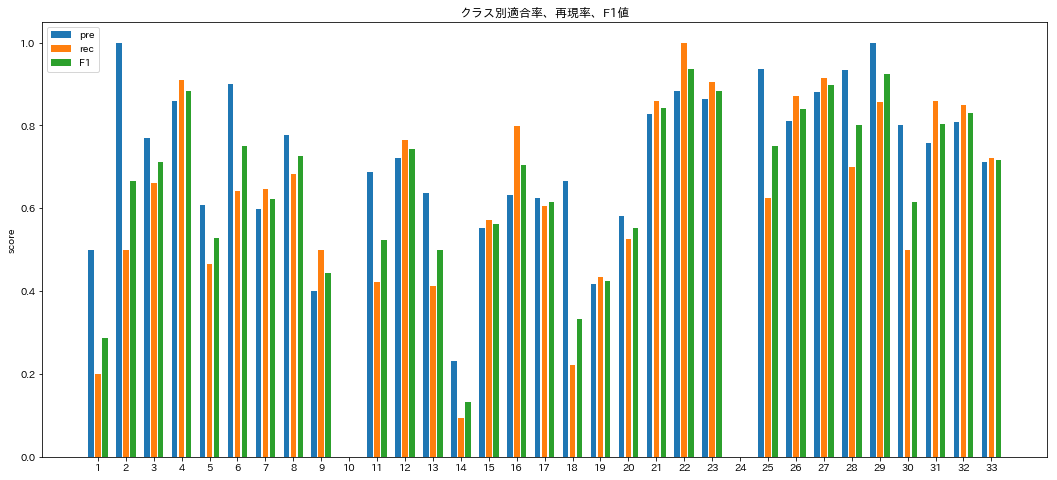

In [14]:
# テストスコアのクラス別適合率、再現率、F1値を計算
pred_test = clf3.predict(X_test)
p_r_f = precision_recall_fscore_support(y_test, pred_test)

# クラス別適合率、再現率、F1値を表示
plt.figure(figsize=(18, 8))
plt.title("クラス別適合率、再現率、F1値")
plt.ylabel("score")
plt.xticks(x)
plt.bar(x-0.25, p_r_f[0], width=0.2, label='pre')
plt.bar(x, p_r_f[1], width=0.2, label='rec')
plt.bar(x+0.25, p_r_f[2], width=0.2, label='F1')
plt.legend(loc=2)    
plt.show()

In [15]:
# SVM
from sklearn.svm import SVC

## パラメーター設定
kernel = 'rbf'

## One-versus-the-rest
clf4 = SVC(kernel=kernel, decision_function_shape='ovr', random_state=42)
clf4.fit(X_train, y_train)
cv_scores = cross_val_score(clf4, X_train, y_train, cv=5)

print("Training score：" + str(clf4.score(X_train, y_train)))
print("Cross-Validation score：" + str(np.mean(cv_scores)))
print("Test score：" + str(clf4.score(X_test, y_test)))
                          

## One-versus-the-one(multi-class default)
clf5 = SVC(kernel=kernel,  decision_function_shape='ovo', random_state=42)
clf5.fit(X_train, y_train)
cv_scores = cross_val_score(clf5, X_train, y_train, cv=5)

print("Training score：" + str(clf5.score(X_train, y_train)))
print("Cross-Validation score：" + str(np.mean(cv_scores)))
print("Test score：" + str(clf5.score(X_test, y_test)))

Training score：0.771933653426
Cross-Validation score：0.715321506851
Test score：0.718463553034
Training score：0.771933653426
Cross-Validation score：0.715321506851
Test score：0.718463553034


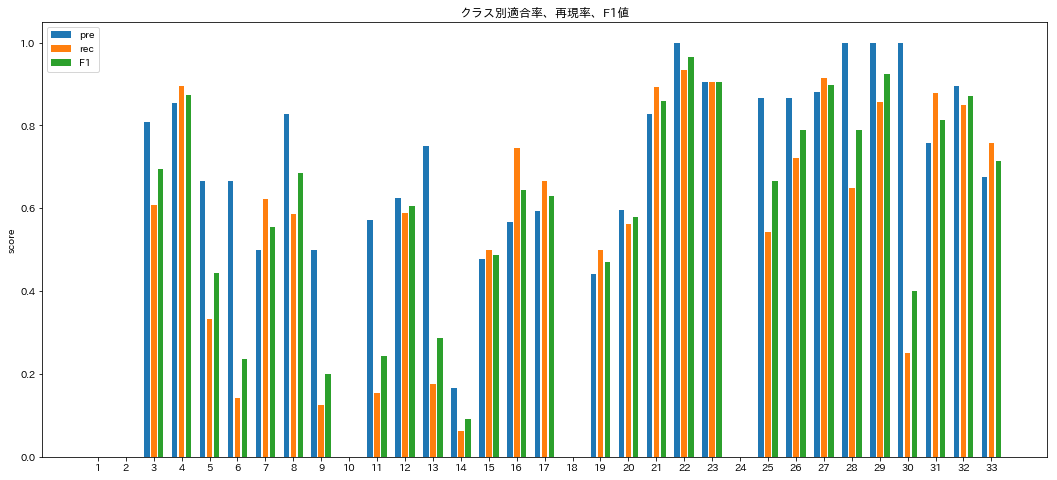

In [16]:
# テストスコアのクラス別適合率、再現率、F1値を計算
pred_test = clf4.predict(X_test)
p_r_f = precision_recall_fscore_support(y_test, pred_test)

# クラス別適合率、再現率、F1値を表示
plt.figure(figsize=(18, 8))
plt.title("クラス別適合率、再現率、F1値")
plt.ylabel("score")
plt.xticks(x)
plt.bar(x-0.25, p_r_f[0], width=0.2, label='pre')
plt.bar(x, p_r_f[1], width=0.2, label='rec')
plt.bar(x+0.25, p_r_f[2], width=0.2, label='F1')
plt.legend(loc=2)    
plt.show()

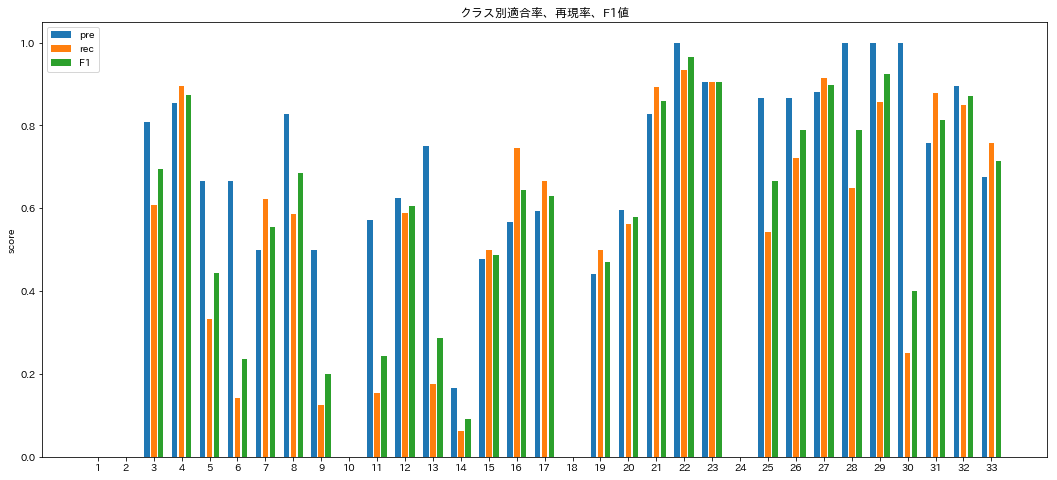

In [17]:
# テストスコアのクラス別適合率、再現率、F1値を計算
pred_test = clf5.predict(X_test)
p_r_f = precision_recall_fscore_support(y_test, pred_test)

# クラス別適合率、再現率、F1値を表示
plt.figure(figsize=(18, 8))
plt.title("クラス別適合率、再現率、F1値")
plt.ylabel("score")
plt.xticks(x)
plt.bar(x-0.25, p_r_f[0], width=0.2, label='pre')
plt.bar(x, p_r_f[1], width=0.2, label='rec')
plt.bar(x+0.25, p_r_f[2], width=0.2, label='F1')
plt.legend(loc=2)    
plt.show()

In [18]:
# LinearSVC
from sklearn.svm import LinearSVC

## One-versus-the-rest(multi-class default)
clf6 = LinearSVC(multi_class='ovr', random_state=42)
clf6.fit(X_train, y_train)
cv_scores = cross_val_score(clf6, X_train, y_train, cv=5)

print("Training score：" + str(clf6.score(X_train, y_train)))
print("Cross-Validation score：" + str(np.mean(cv_scores)))
print("Test score：" + str(clf6.score(X_test, y_test)))
                          

## crammer_singer
clf7 = LinearSVC(multi_class='crammer_singer', random_state=42)
clf7.fit(X_train, y_train)
cv_scores = cross_val_score(clf7, X_train, y_train, cv=5)

print("Training score：" + str(clf7.score(X_train, y_train)))
print("Cross-Validation score：" + str(np.mean(cv_scores)))
print("Test score：" + str(clf7.score(X_test, y_test)))

Training score：0.781536446966
Cross-Validation score：0.716520563826
Test score：0.719336534265
Training score：0.816237450895
Cross-Validation score：0.704801065993
Test score：0.716281099956


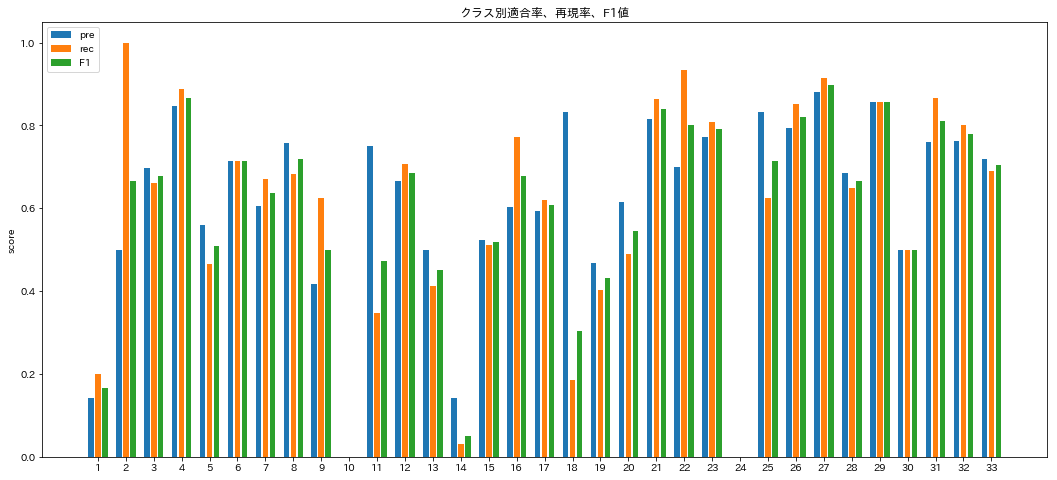

In [19]:
# テストスコアのクラス別適合率、再現率、F1値を計算
pred_test = clf6.predict(X_test)
p_r_f = precision_recall_fscore_support(y_test, pred_test)

# クラス別適合率、再現率、F1値を表示
plt.figure(figsize=(18, 8))
plt.title("クラス別適合率、再現率、F1値")
plt.ylabel("score")
plt.xticks(x)
plt.bar(x-0.25, p_r_f[0], width=0.2, label='pre')
plt.bar(x, p_r_f[1], width=0.2, label='rec')
plt.bar(x+0.25, p_r_f[2], width=0.2, label='F1')
plt.legend(loc=2)    
plt.show()

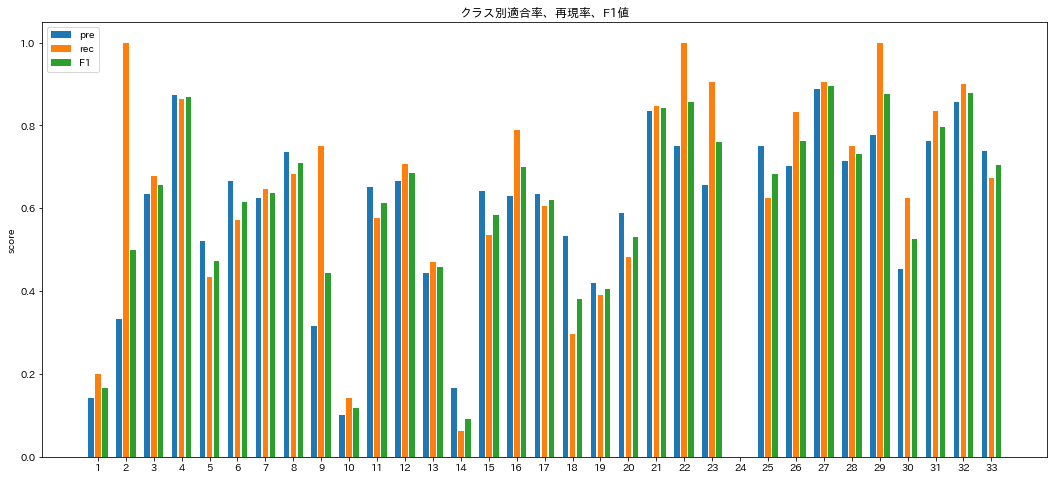

In [20]:
# テストスコアのクラス別適合率、再現率、F1値を計算
pred_test = clf7.predict(X_test)
p_r_f = precision_recall_fscore_support(y_test, pred_test)

# クラス別適合率、再現率、F1値を表示
plt.figure(figsize=(18, 8))
plt.title("クラス別適合率、再現率、F1値")
plt.ylabel("score")
plt.xticks(x)
plt.bar(x-0.25, p_r_f[0], width=0.2, label='pre')
plt.bar(x, p_r_f[1], width=0.2, label='rec')
plt.bar(x+0.25, p_r_f[2], width=0.2, label='F1')
plt.legend(loc=2)    
plt.show()